In [1]:
import sys
import numpy as np
from numpy import array
from pandas import read_csv, DataFrame, Series, concat
from matplotlib.pyplot import figure, savefig, show, subplots
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from scipy.stats import norm, expon, lognorm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../../../../utils')
from dslabs_functions import get_variable_types, \
  CLASS_EVAL_METRICS, plot_multiline_chart, plot_evaluation_results, \
  HEIGHT, run_NB, run_KNN, plot_multibar_chart, \
  plot_confusion_matrix, NR_STDEV, determine_outlier_thresholds_for_var
from studies import naive_Bayes_study, knn_study

def evaluate_approach(
    data: DataFrame, 
    target: str = "class", 
    metric: str = "recall",
    test_size: float = 0.3,
    random_state: int = 42
) -> dict[str, list]:
    df = data.copy()
    
    y = df.pop(target).values
    X = df.values
    
    # Split the data
    trnX, tstX, trnY, tstY = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
        eval["confusion_matrix"] = [eval_NB["confusion_matrix"], eval_KNN["confusion_matrix"]]
    
    return eval

def evaluate_and_plot(
    df: DataFrame,
    file_tag: str,
    task: str,
    approach: str,
    target_name: str = "class"
) -> None:
    figure()
    eval: dict[str, list] = evaluate_approach(data=df, target=target_name)
    plot_multibar_chart(
        ["NB", "KNN"], {k: v for k, v in eval.items() if k != "confusion_matrix"}, title=f"{file_tag}-{task}-{approach} evaluation", percentage=True
    )
    show()

    fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    labels = df[target_name].unique()
    labels.sort()
    plot_confusion_matrix(eval["confusion_matrix"][0], labels, ax=axs[0])
    axs[0].set_title(f"{file_tag}-{task}-{approach} NB Confusion Matrix")
    plot_confusion_matrix(eval["confusion_matrix"][1], labels, ax=axs[1])
    axs[1].set_title(f"{file_tag}-{task}-{approach} KNN Confusion Matrix")
    show()


In [2]:
def best_model_nb(
    features_train: DataFrame,
    target_train: DataFrame,
    features_test: DataFrame,
    target_test: DataFrame,
    lab_folder: str,
    file_tag: str,
    approach: str,
    eval_metric: str = "accuracy"
) -> {DataFrame, DataFrame}:
    figure()
    nb_best_model_acc, nb_params_acc = naive_Bayes_study(
        features_train,
        target_train,
        features_test,
        target_test,
        metric=eval_metric
    )
    savefig(f"../../charts/{lab_folder}/{file_tag}_{approach}_nb_{eval_metric}_study.png", bbox_inches='tight')
    show()
    return nb_best_model_acc, nb_params_acc

In [3]:
def best_model_knn(
    features_train: DataFrame,
    target_train: DataFrame,
    features_test: DataFrame,
    target_test: DataFrame,
    lab_folder: str,
    file_tag: str,
    approach: str,
    k_max: int = 25,
    lag: int = 2,
    eval_metric: str = "accuracy"
) :
    
    figure()
    knn_best_model, knn_params = knn_study(
        features_train,
        target_train,
        features_test,
        target_test,
        k_max,
        lag,
        metric=eval_metric,
    )
    savefig(f"../../charts/{lab_folder}/{file_tag}_{approach}_knn_{eval_metric}_study.png", bbox_inches='tight')
    show()     
    return knn_best_model, knn_params  

In [4]:
def knn_overfitting(
    features_train: DataFrame,
    target_train: DataFrame,
    features_test: DataFrame,
    target_test: DataFrame,
    params: DataFrame,
    lab_folder: str,
    file_tag: str,
    approach: str,
    k_max: int = 25,
    lag: int = 2,
    acc_metric: str = "accuracy"
):
    distance = params["params"][1]   # best distance from KNN study, e.g. 'euclidean'
    kvalues = [i for i in range(1, k_max + 1, lag)]

    y_tst_values = []
    y_trn_values = []
    
    for k in kvalues:
        clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
        clf.fit(features_train, target_train)
        prd_tst_Y = clf.predict(features_test)
        prd_trn_Y = clf.predict(features_train)

        y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](target_test, prd_tst_Y))
        y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](target_train, prd_trn_Y))
                        
    figure()
    plot_multiline_chart(
        kvalues,
        {"Train": y_trn_values, "Test": y_tst_values},
        title=f"KNN overfitting study for {distance}",
        xlabel="K",
        ylabel=acc_metric,
        percentage=True,
    )
    savefig(f"../charts/{lab_folder}/{file_tag}_{approach}_knn_overfitting.png", bbox_inches='tight')
    show()

In [5]:
def predict_eval(features_train: DataFrame,
    target_train: DataFrame,
    features_test: DataFrame,
    target_test: DataFrame,
    best_model: DataFrame,
    params: DataFrame,
    lab_folder: str,
    file_tag: str,
    approach: str
) -> None:
    prd_trn = best_model.predict(features_train)
    prd_tst = best_model.predict(features_test)
    nb_labels = sorted(np.unique(target_train))

    figure()
    plot_evaluation_results(
        params,
        array(target_train),
        array(prd_trn),
        array(target_test),
        array(prd_tst),
        nb_labels
    )
    savefig(f'../../charts/{lab_folder}/{file_tag}_{approach}_{params["name"]}_best_{params["metric"]}_eval.png', bbox_inches='tight')
    show()

In [6]:
def separate_train_test(
    data: DataFrame, 
    target: str, 
    test_size: float,
    random_state: int
) -> {DataFrame, DataFrame, DataFrame, DataFrame}:
    df = data.copy()
    
    y = df.pop(target).values
    X = df.values
    
    # Split the data
    trnX, tstX, trnY, tstY = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    return trnX, tstX, trnY, tstY

In [7]:
filename = "../../data/prepared/traffic_enc1.csv"
file_tag = "traffic"
lab_folder = "lab3_preparation/outliers"
target_name = "crash_type"
data: DataFrame = read_csv(filename, na_values="")
variable_types: dict[str, list] = get_variable_types(data)
data.shape

(209306, 150)

### **Outliers** ###

### Approach 1 ###

In [8]:
task = "outliers"
approach_1 = "drop_outliers"

In [9]:
n_std: int = NR_STDEV
numeric_vars: list[str] = get_variable_types(data)["numeric"]
if numeric_vars is not None:
    df_1: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
            summary5[var]
        )
        outliers: Series = df_1[(df_1[var] > top_threshold) | (df_1[var] < bottom_threshold)]
        df_1.drop(outliers.index, axis=0, inplace=True)
    df_1.to_csv(f"../../data/prepared/{file_tag}_{task}_{approach_1}.csv", index=True)
    print(f"Data after dropping outliers: {df_1.shape}")
else:
    print("There are no numeric variables")

Data after dropping outliers: (138419, 150)


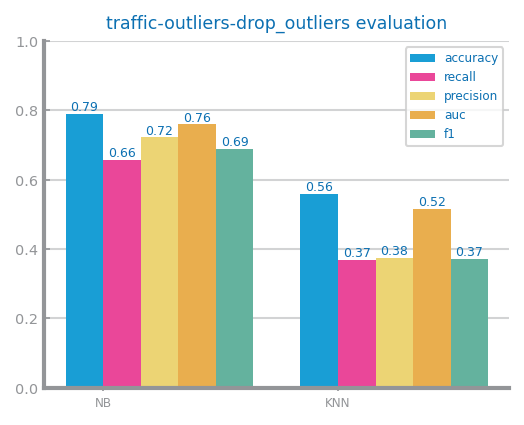

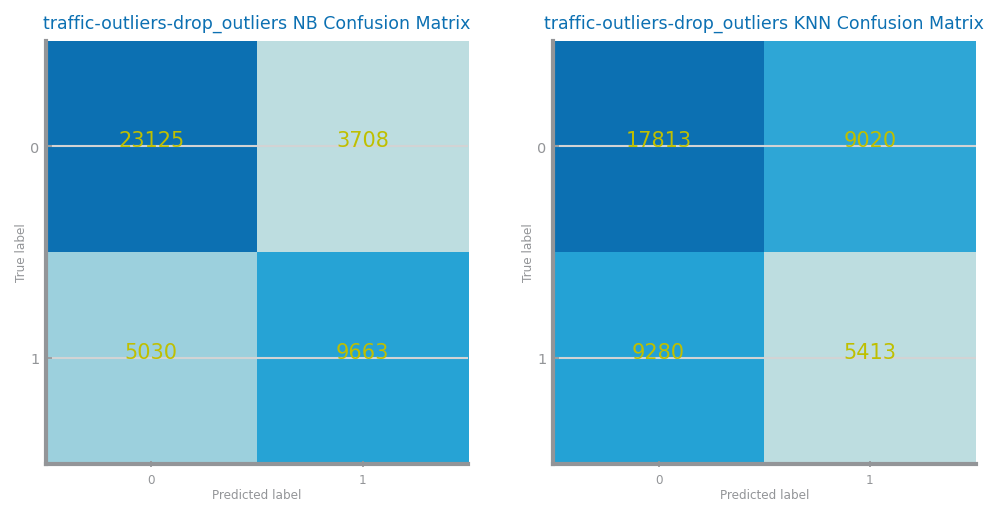

In [10]:
evaluate_and_plot(df_1, file_tag, task, approach_1, target_name)

In [11]:
trnX_1, tstX_1, trnY_1, tstY_1 = separate_train_test(df_1, target_name, 0.3, 42)    

**NAIVE BAYES ANALYSIS - 1**

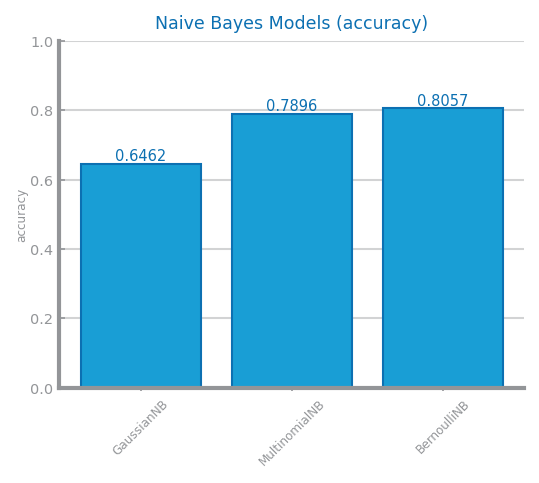

In [12]:
nb_best_model_acc_1, nb_params_acc_1 = best_model_nb(
    trnX_1, trnY_1, tstX_1, tstY_1, 
    lab_folder, file_tag, approach_1,
    eval_metric = "accuracy"
) 

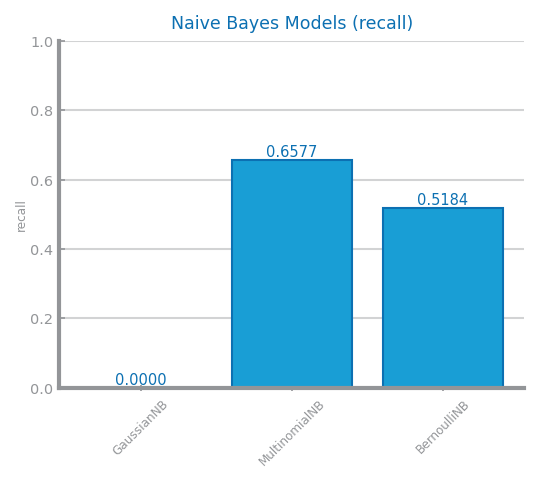

In [13]:
nb_best_model_rec_1, nb_params_rec_1 = best_model_nb(
    trnX_1, trnY_1, tstX_1, tstY_1, 
    lab_folder, file_tag, approach_1,
    eval_metric = "recall"
) 

<Figure size 600x450 with 0 Axes>

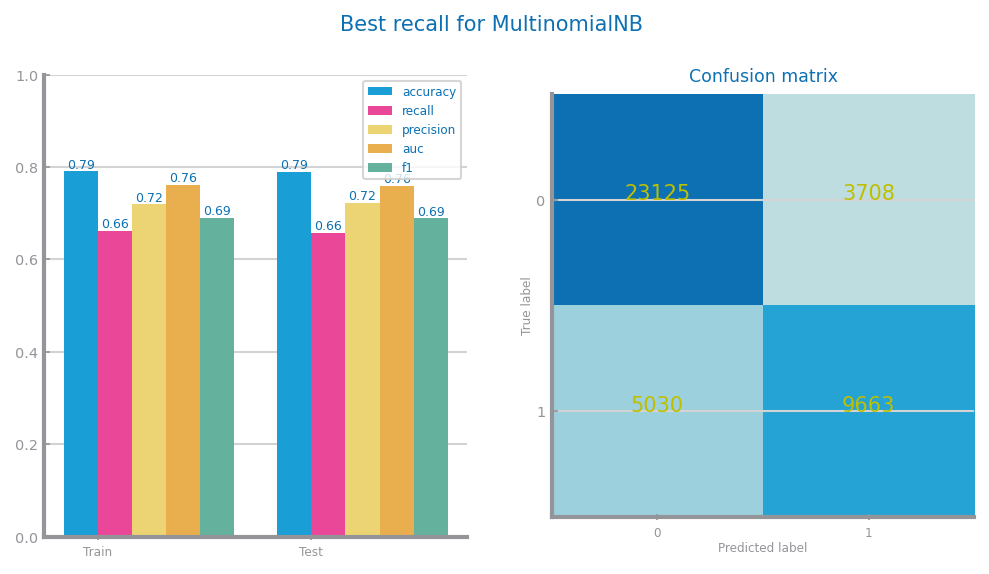

In [14]:
predict_eval(trnX_1, trnY_1, tstX_1, tstY_1, 
    nb_best_model_rec_1, nb_params_rec_1,
    lab_folder, file_tag, approach_1,
)

**KNN ANALYSIS - 1**

In [ ]:
knn_best_model_acc_1, knn_params_acc_1 = best_model_knn(
    trnX_1, trnY_1, tstX_1, tstY_1, 
    lab_folder, file_tag, approach_1,
    k_max=20, lag=5, eval_metric = "accuracy"
) 

In [ ]:
predict_eval(trnX_1, trnY_1, tstX_1, tstY_1, 
    knn_best_model_acc_1, knn_params_acc_1 ,
    lab_folder, file_tag, approach_1,
)

In [ ]:
knn_overfitting(trnX_1, trnY_1, tstX_1, tstY_1, 
    knn_params_acc_1, lab_folder, file_tag, approach_1,
    k_max=20, lag=5, eval_metric = "accuracy"
)

### Approach 2 ###

In [15]:
approach_2 = "replacing_outliers"

In [16]:
if [] != numeric_vars:
    df_2: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df_2[var].median()
        df_2[var] = df_2[var].apply(lambda x: median if x > top or x < bottom else x)
    df_2.to_csv(f"../../data/prepared/{file_tag}_{task}_{approach_2}.csv", index=True)
    print("Data after replacing outliers:", df_2.shape)
    print(df_2.describe())
else:
    print("There are no numeric variables")

Data after replacing outliers: (209306, 150)
         crash_date     crash_type  intersection_related_i         damage  \
count  2.093060e+05  209306.000000           209306.000000  209306.000000   
mean   1.609386e+18       0.439213                0.952309       1.803111   
std    7.425389e+16       0.496292                0.213112       0.397649   
min    1.454883e+18       0.000000                0.000000       1.000000   
25%    1.546545e+18       0.000000                1.000000       2.000000   
50%    1.608397e+18       0.000000                1.000000       2.000000   
75%    1.673145e+18       1.000000                1.000000       2.000000   
max    1.737159e+18       1.000000                1.000000       2.000000   

       num_units  most_severe_injury  injuries_total  injuries_fatal  \
count   209306.0       209306.000000   209306.000000        209306.0   
mean         2.0            0.378054        0.183358             0.0   
std          0.0            0.732383        0

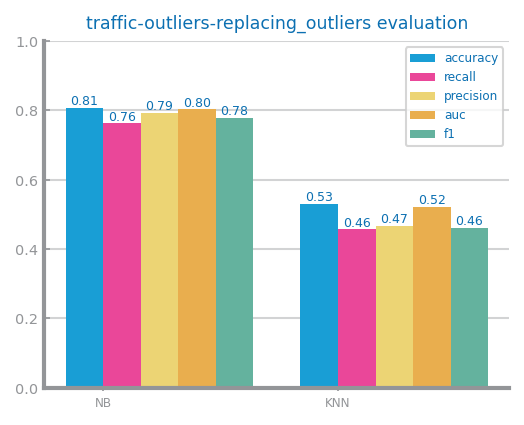

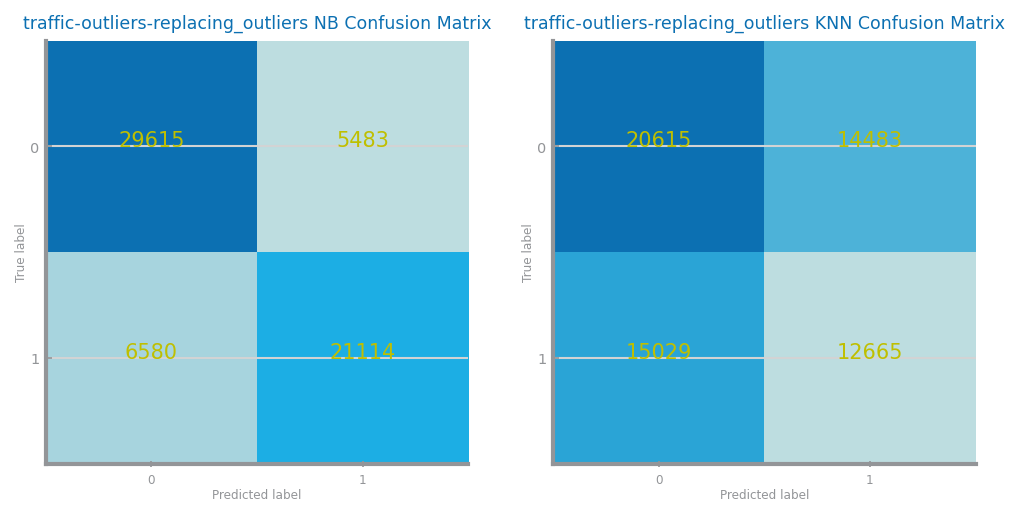

In [17]:
evaluate_and_plot(df_2, file_tag, task, approach_2, target_name)

In [18]:
trnX_2, tstX_2, trnY_2, tstY_2 = separate_train_test(df_2, target_name, 0.3, 42)    

**NAIVE BAYES ANALYSIS - 2**

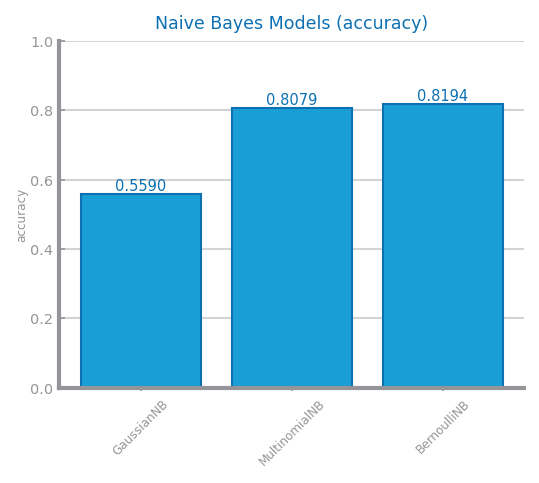

In [19]:
nb_best_model_acc_2, nb_params_acc_2 = best_model_nb(
    trnX_2, trnY_2, tstX_2, tstY_2, 
    lab_folder, file_tag, approach_2,
    eval_metric = "accuracy"
) 

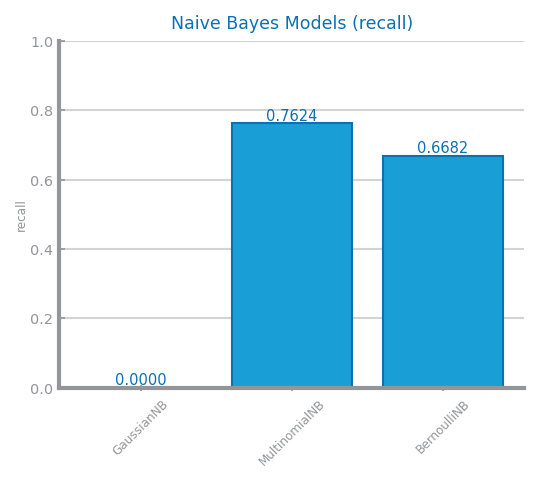

(MultinomialNB(),
 {'name': 'MultinomialNB',
  'metric': 'recall',
  'params': (),
  'recall': 0.7624034086805807})

In [20]:
best_model_nb(trnX_2, trnY_2, tstX_2, tstY_2, 
    lab_folder, file_tag, approach_2,
    eval_metric = "recall"
) 

<Figure size 600x450 with 0 Axes>

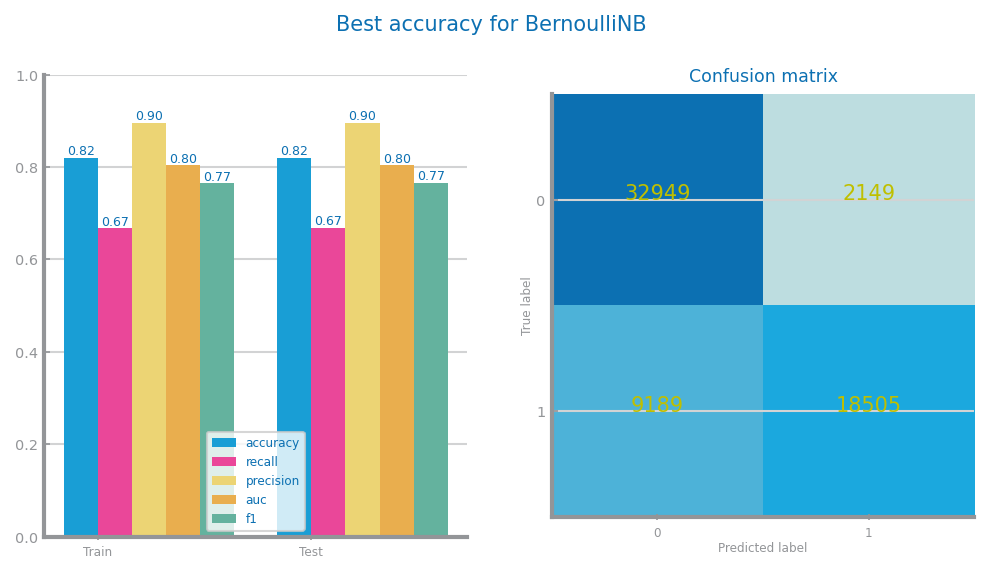

In [21]:
predict_eval(trnX_2, trnY_2, tstX_2, tstY_2, 
    nb_best_model_acc_2, nb_params_acc_2,
    lab_folder, file_tag, approach_2,
)

**KNN ANALYSIS - 2**

In [ ]:
knn_best_model_acc_2, knn_params_acc_2 = best_model_knn(trnX_2, trnY_2, tstX_2,  tstY_2, 
    lab_folder, file_tag, approach_2,
    k_max=20, lag=5, eval_metric = "accuracy"
) 

In [ ]:
predict_eval(trnX_2, trnY_2, tstX_2, tstY_2, 
    knn_best_model_acc_2, knn_params_acc_2,
    lab_folder, file_tag, approach_2,
)

In [ ]:
knn_overfitting(trnX_2, trnY_2, tstX_2, tstY_2, 
    knn_params_acc_2, lab_folder, file_tag, approach_2,
    k_max=20, lag=5, eval_metric = "accuracy"
)

### Approach 3 ###

In [22]:
approach_3 = "truncate_outliers"

In [23]:
if [] != numeric_vars:
    df_3: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        df_3[var] = df_3[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    df_3.to_csv(f"../../data/prepared/{file_tag}_{task}_{approach_3}.csv", index=True)
    print("Data after truncating outliers:", df_3.shape)
    print(df_3.describe())
else:
    print("There are no numeric variables")

Data after truncating outliers: (209306, 150)
         crash_date     crash_type  intersection_related_i         damage  \
count  2.093060e+05  209306.000000           209306.000000  209306.000000   
mean   1.607552e+18       0.439213                0.952309       1.632463   
std    7.612836e+16       0.496292                0.213112       0.595890   
min    1.454876e+18       0.000000                0.000000       0.281394   
25%    1.543832e+18       0.000000                1.000000       1.000000   
50%    1.608396e+18       0.000000                1.000000       2.000000   
75%    1.673145e+18       1.000000                1.000000       2.000000   
max    1.737159e+18       1.000000                1.000000       2.000000   

           num_units  most_severe_injury  injuries_total  injuries_fatal  \
count  209306.000000       209306.000000   209306.000000   209306.000000   
mean        2.042713            0.451443        0.336197        0.000162   
std         0.250924            

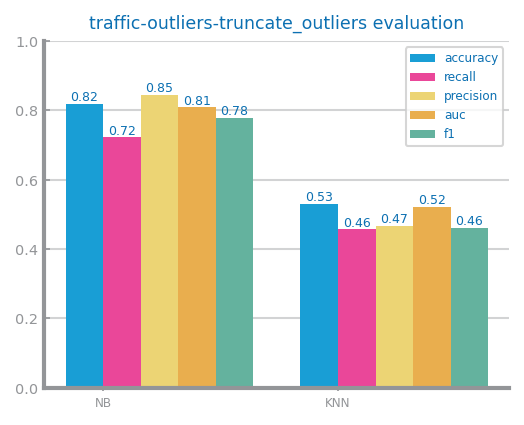

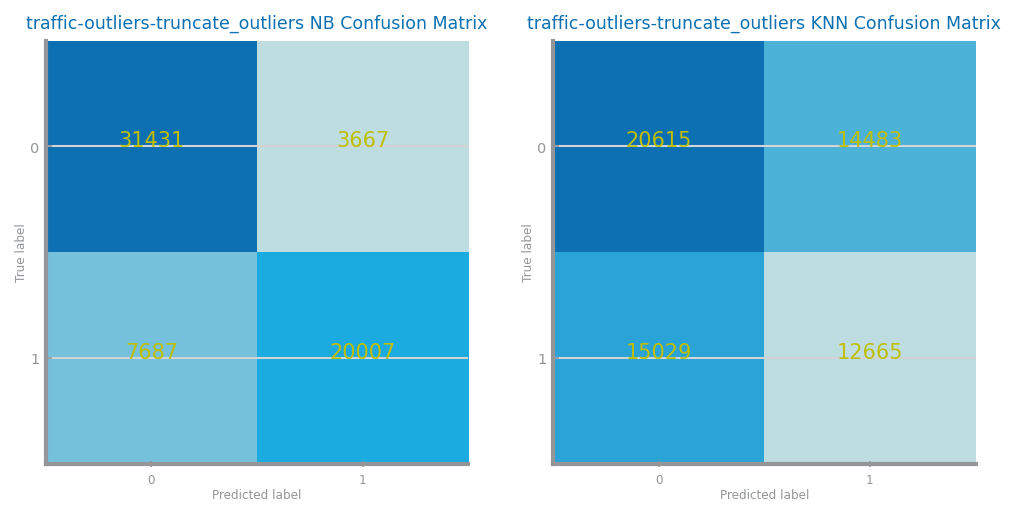

In [24]:
evaluate_and_plot(df_3, file_tag, task, approach_3, target_name)

In [25]:
trnX_3, tstX_3, trnY_3, tstY_3 = separate_train_test(df_3, target_name, 0.3, 42)    

**NAIVE BAYES ANALYSIS - 3**

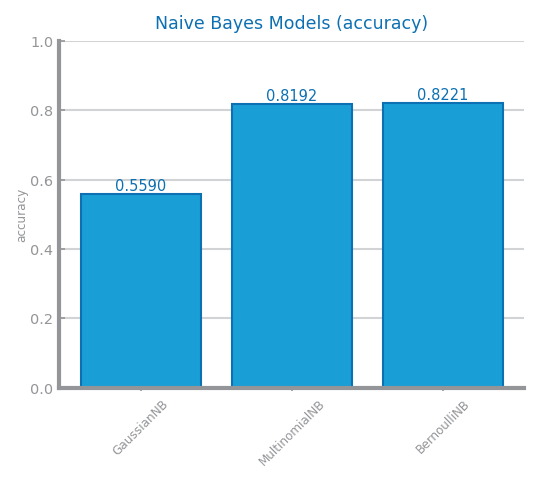

In [26]:
nb_best_model_acc_3, nb_params_acc_3 = best_model_nb(
    trnX_3, trnY_3, tstX_3, tstY_3, 
    lab_folder, file_tag, approach_3,
    eval_metric = "accuracy"
) 

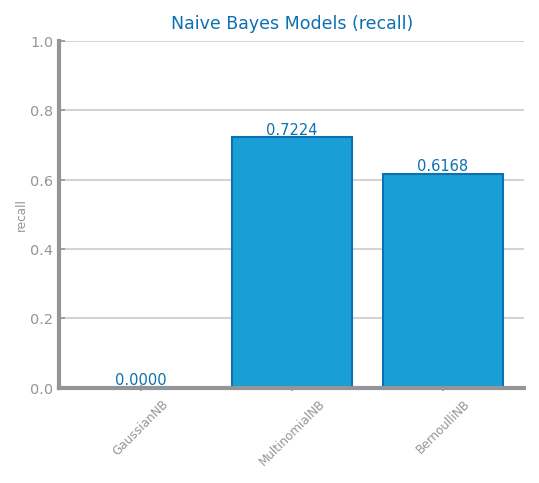

(MultinomialNB(),
 {'name': 'MultinomialNB',
  'metric': 'recall',
  'params': (),
  'recall': 0.722430851447967})

In [27]:
best_model_nb(trnX_3, trnY_3, tstX_3,  tstY_3, 
    lab_folder, file_tag, approach_3,
    eval_metric = "recall"
) 

<Figure size 600x450 with 0 Axes>

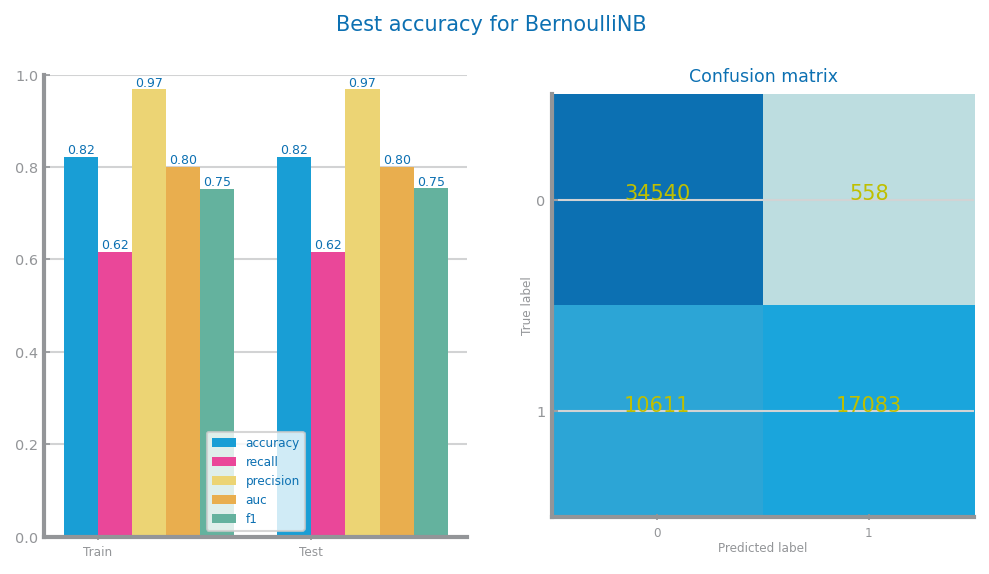

In [28]:
predict_eval(trnX_3, trnY_3, tstX_3, tstY_3, 
    nb_best_model_acc_3, nb_params_acc_3,
    lab_folder, file_tag, approach_3,
)

**KNN ANALYSIS - 3**

In [ ]:
knn_best_model_acc_3, knn_params_acc_3 = best_model_knn(
    trnX_3, trnY_3, tstX_3, tstY_3, 
    lab_folder, file_tag, approach_3,
    k_max=20, lag=5, eval_metric = "accuracy"
) 

In [ ]:
predict_eval(trnX_3, trnY_3, tstX_3, tstY_3, 
    knn_best_model_acc_3, knn_params_acc_3,
    lab_folder, file_tag, approach_3,
)

In [ ]:
knn_overfitting(trnX_3, trnY_3, tstX_3, tstY_3, 
    knn_params_acc_3, lab_folder, file_tag, approach_3,
    k_max=20, lag=5, eval_metric = "accuracy"
)